# Check training

In [1]:
import sys

sys.path.insert(0, "../code")

In [2]:
from utils import get_train_test_loaders

In [3]:
train_labelled_loader, train_unlabelled_loader, test_loader = \
    get_train_test_loaders(dataset_name="CIFAR10", 
                           num_labelled_samples=4000,
                           path="../input/cifar10",
                           batch_size=16,
                           unlabelled_batch_size=32,
                           pin_memory=False,
                           num_workers=12)


Files already downloaded and verified


In [4]:
from utils import get_model

In [5]:
device = "cpu"
batch_size = 16
num_epochs = 200
config = {
    "dataset": "CIFAR10",
    "data_path": ".",

    "model": "fastresnet",

    "momentum": 0.9,
    "weight_decay": 1e-4,
    "batch_size": batch_size,
    "unlabelled_batch_size": 320,
    "num_workers": 10,

    "num_epochs": num_epochs,

    "lr_milestones_values": [(0, 0.0), (5, 1.0), (num_epochs, 0.0)],

    "num_labelled_samples": 4000,
}


In [6]:
model = get_model(config['model'])
model = model.to(device)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.0,
                      momentum=config['momentum'],
                      weight_decay=config['weight_decay'],
                      nesterov=True)

criterion = nn.CrossEntropyLoss()

In [15]:
consistency_criterion = nn.KLDivLoss(reduction="batchmean")

In [10]:
from ignite.contrib.handlers import PiecewiseLinear


le = len(train_labelled_loader)
milestones_values = [(le * m, v) for m, v in config['lr_milestones_values']]
scheduler = PiecewiseLinear(optimizer, "lr", milestones_values=milestones_values)

def _prepare_batch(batch, device, non_blocking):
    x, y = batch
    return (convert_tensor(x, device=device, non_blocking=non_blocking),
            convert_tensor(y, device=device, non_blocking=non_blocking))

def cycle(iterable):
    while True:
        for i in iterable:
            yield i

train_unlabelled_loader_iter = cycle(train_unlabelled_loader)
train_labelled_loader_iter = cycle(train_labelled_loader)

In [11]:
unsup_x, unsup_aug_x = next(train_unlabelled_loader_iter)
labelled_batch = next(train_labelled_loader_iter)

In [12]:
from ignite.utils import convert_tensor


x, y = _prepare_batch(labelled_batch, device=device, non_blocking=True)
unsup_x = convert_tensor(unsup_x, device=device, non_blocking=True)
unsup_aug_x = convert_tensor(unsup_aug_x, device=device, non_blocking=True)


In [13]:
model.train()
# Supervised part        
y_pred = model(x)

In [16]:
# Unsupervised part
unsup_orig_y_pred = model(unsup_x).detach()
unsup_orig_y_probas = torch.softmax(unsup_orig_y_pred, dim=-1)

unsup_aug_y_pred = model(unsup_aug_x)
unsup_aug_y_probas = torch.log_softmax(unsup_aug_y_pred, dim=-1)

consistency_loss = consistency_criterion(unsup_aug_y_probas, unsup_orig_y_probas)


In [17]:
consistency_loss

tensor(0.0008, grad_fn=<DivBackward0>)

Compare LR scheduling with original implementation:
https://github.com/google-research/uda/blob/master/image/main.py

In [20]:
import tensorflow as tf
tf.__version__

'1.13.1'

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
learning_rate = 0.03
train_steps = 400
min_lr_ratio = 0.004
warmup_steps = 20

In [219]:
tf.reset_default_graph()

global_step = tf.placeholder(dtype='int32')


# increase the learning rate linearly
if warmup_steps > 0:
    warmup_lr = tf.to_float(global_step) / tf.to_float(warmup_steps) * learning_rate
else:
    warmup_lr = 0.0


decay_lr = tf.train.cosine_decay(
    learning_rate,
    global_step=global_step - warmup_steps,
    decay_steps=train_steps - warmup_steps,
    alpha=min_lr_ratio)

learning_rate = tf.where(global_step < warmup_steps,
                         warmup_lr, decay_lr)

sess = tf.Session()
lrs = []
for i in np.arange(0, train_steps):
    lrs.append(sess.run(learning_rate, feed_dict={global_step: i}))    

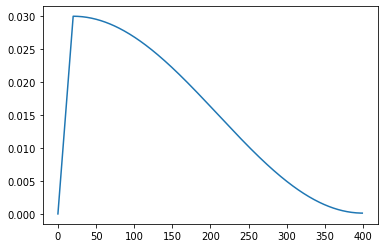

In [220]:
plt.plot(np.arange(0, train_steps), lrs)

In [221]:
lrs[0], lrs[1], lrs[2], lrs[3]

(0.0, 0.0015, 0.003, 0.0045)

In [222]:
lrs[warmup_steps - 1], lrs[warmup_steps], lrs[warmup_steps + 1]

(0.0285, 0.03, 0.029999489)

In [259]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.optim as optim

from ignite.contrib.handlers import create_lr_scheduler_with_warmup

In [260]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [261]:
learning_rate = 0.03
train_steps = 400
min_lr_ratio = 0.004
warmup_steps = 20

In [262]:
t = torch.tensor([0.0])
optimizer = optim.SGD([t], lr=0.0)

In [281]:
eta_min = learning_rate * min_lr_ratio
num_warmup_steps = warmup_steps        

cosine_lr_decay = CosineAnnealingLR(optimizer, eta_min=eta_min, T_max=train_steps - warmup_steps)

lr_scheduler = create_lr_scheduler_with_warmup(cosine_lr_decay,
                                               warmup_start_value=0.0, 
                                               warmup_end_value=learning_rate * (1.0 + 1.0 / warmup_steps),
                                               warmup_duration=warmup_steps)


In [282]:
lrs2 = []
for i in np.arange(0, train_steps):    
    lr_scheduler(None)
    lrs2.append(optimizer.param_groups[0]['lr'])
    optimizer.step()


In [283]:
lrs2[:10], np.array(lrs2).max()

([0.0,
  0.001575,
  0.00315,
  0.004725,
  0.0063,
  0.007875,
  0.00945,
  0.011025,
  0.0126,
  0.014175],
 0.029925)

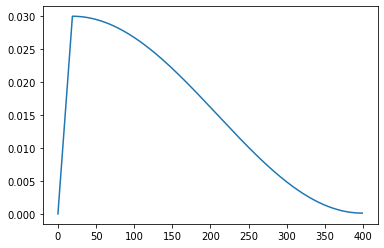

In [284]:
plt.plot(np.arange(0, train_steps), lrs2)

In [285]:
lrs[warmup_steps - 2], lrs[warmup_steps - 1], lrs[warmup_steps], lrs[warmup_steps + 1]

(0.027, 0.0285, 0.03, 0.029999489)

In [286]:
lrs2[warmup_steps - 2], lrs2[warmup_steps - 1], lrs2[warmup_steps], lrs2[warmup_steps + 1]

(0.02835, 0.029925, 0.02992449071696036, 0.029922962902650268)

In [237]:
lrs[warmup_steps], lrs[warmup_steps + 1], lrs[warmup_steps + 2], lrs[warmup_steps + 3]

(0.03, 0.029999489, 0.02999796, 0.029995404)

In [238]:
lrs2[warmup_steps], lrs2[warmup_steps + 1], lrs2[warmup_steps + 2], lrs2[warmup_steps + 3]

(0.03, 0.029999489435422768, 0.029997957776587487, 0.029995405128181)

In [239]:
lrs2[-1], lrs[-1]

(0.00012051056457723179, 0.00012051025)

In [240]:
np.array(lrs).shape, np.array(lrs2).shape

((400,), (400,))

In [241]:
np.max(lrs2)

0.03

In [242]:
lrs[0], lrs2[0]

(0.0, 0.0)

In [243]:
np.testing.assert_almost_equal(np.array(lrs), np.array(lrs2))